<a href="https://colab.research.google.com/github/manishsethi/Automation-tasks/blob/main/Assignment-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group 103
### Group Members Name with Student ID:

1. 2023AD05049 - Unnikrishnan M.K. -  100%
2. 2023ac05135 - Manish Sethi      -  100%
3. 2023ac05626 - Avinash Singh     -  100%
4. 2023ac05669 - Kushagra Lonaria  -  100%

In [1]:
# -- GANs, WGAN-GP, and SNGAN on MNIST --
# (Colab notebook ready; copy-paste into a new cell in Colab)

!pip install torch torchvision matplotlib -q

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs('samples_gan', exist_ok=True)
os.makedirs('samples_wgan', exist_ok=True)
os.makedirs('samples_sngan', exist_ok=True)

# DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
mnist = datasets.MNIST('.', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=128, shuffle=True, num_workers=2)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.2 MB/s eta 0:00:00


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.60MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.99MB/s]


In [2]:
# GAN Generator & Discriminator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(100, 256), nn.ReLU(True),
            nn.Linear(256, 512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.ReLU(True),
            nn.Linear(1024, 28*28), nn.Tanh()
        )
    def forward(self, z): return self.seq(z).view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(28*28, 512), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.seq(x.view(-1, 28*28))


In [3]:
# WGAN Generator: same architecture as GAN
# WGAN Discriminator (no Sigmoid, outputs real values)
class WDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(28*28, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.seq(x.view(-1,28*28))

def gradient_penalty(D, real, fake):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    pred = D(interp)
    grad = torch.autograd.grad(pred, interp, torch.ones_like(pred),
                               create_graph=True)[0]
    return ((grad.view(grad.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()


In [4]:
from torch.nn.utils import spectral_norm

class SNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            spectral_norm(nn.Linear(28*28, 512)), nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(512, 256)), nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(256, 1))
        )
    def forward(self, x): return self.seq(x.view(-1, 28*28))
# (Generator the same as GAN)


In [5]:
def save_samples(generator, epoch, out_dir):
    with torch.no_grad():
        z = torch.randn(64, 100, device=device)
        imgs = generator(z)
        grid = utils.make_grid((imgs + 1) / 2, nrow=8)
        utils.save_image(grid, f"{out_dir}/epoch_{epoch:03d}.png")

def plot_loss_curves(loss_dict):
    plt.figure(figsize=(10,5))
    for name, (gl, dl) in loss_dict.items():
        plt.plot(gl, label=f"{name} G")
        plt.plot(dl, label=f"{name} D")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Generator/Discriminator Losses")
    plt.legend()
    plt.show()

# Training Loops
def train_gan(generator, discriminator, loader, out_dir, epochs=50):
    g, d = generator, discriminator
    g, d = g.to(device), d.to(device)
    opt_g = optim.Adam(g.parameters(), lr=2e-4, betas=(0.5,0.999))
    opt_d = optim.Adam(d.parameters(), lr=2e-4, betas=(0.5,0.999))
    bce = nn.BCELoss()
    g_loss, d_loss = [], []
    for epoch in range(1, epochs+1):
        gl, dl = 0, 0
        for real, _ in loader:
            bs = real.size(0)
            real, z = real.to(device), torch.randn(bs, 100, device=device)
            # Train D
            opt_d.zero_grad()
            fake = g(z)
            loss_d = bce(d(real), torch.ones(bs,1,device=device)) + \
                     bce(d(fake.detach()), torch.zeros(bs,1,device=device))
            loss_d.backward(), opt_d.step()
            # Train G
            opt_g.zero_grad()
            loss_g = bce(d(fake), torch.ones(bs,1,device=device))
            loss_g.backward(), opt_g.step()
            gl += loss_g.item(); dl += loss_d.item()
        g_loss.append(gl/len(loader)); d_loss.append(dl/len(loader))
        save_samples(g, epoch, out_dir)
    return g_loss, d_loss

def train_wgan(generator, discriminator, loader, out_dir, epochs=50, gp_lambda=10):
    g = generator.to(device)
    d = discriminator.to(device)
    opt_g = optim.Adam(g.parameters(), lr=1e-4, betas=(0.0, 0.9))
    opt_d = optim.Adam(d.parameters(), lr=1e-4, betas=(0.0, 0.9))
    g_loss, d_loss = [], []
    for epoch in range(1, epochs + 1):
        gl, dl = 0, 0
        for real, _ in loader:
            bs = real.size(0)
            real, z = real.to(device), torch.randn(bs, 100, device=device)
            # Train D n_critic times
            for _ in range(5):
                fake = g(z).detach()
                d_real = d(real).mean()
                d_fake = d(fake).mean()
                gp = gradient_penalty(d, real, fake)
                loss_d = d_fake - d_real + gp_lambda * gp
                opt_d.zero_grad(); loss_d.backward(); opt_d.step()
            # Train G
            fake = g(z)
            loss_g = -d(fake).mean()
            opt_g.zero_grad(); loss_g.backward(); opt_g.step()
            gl += loss_g.item(); dl += loss_d.item()
        g_loss.append(gl / len(loader)); d_loss.append(dl / len(loader))
        save_samples(g, epoch, out_dir)
    return g_loss, d_loss

def train_sngan(generator, discriminator, loader, out_dir, epochs=50):
    g, d = generator.to(device), discriminator.to(device)
    opt_g = optim.Adam(g.parameters(), lr=2e-4, betas=(0.5,0.999))
    opt_d = optim.Adam(d.parameters(), lr=2e-4, betas=(0.5,0.999))
    bce = nn.BCEWithLogitsLoss()
    g_loss, d_loss = [], []
    for epoch in range(1, epochs+1):
        gl, dl = 0, 0
        for real, _ in loader:
            bs = real.size(0)
            real, z = real.to(device), torch.randn(bs, 100, device=device)
            # D
            opt_d.zero_grad()
            fake = g(z)
            loss_d = bce(d(real), torch.ones(bs,1,device=device)) + \
                     bce(d(fake.detach()), torch.zeros(bs,1,device=device))
            loss_d.backward(); opt_d.step()
            # G
            opt_g.zero_grad()
            loss_g = bce(d(fake), torch.ones(bs,1,device=device))
            loss_g.backward(); opt_g.step()
            gl += loss_g.item(); dl += loss_d.item()
        g_loss.append(gl/len(loader)); d_loss.append(dl/len(loader))
        save_samples(g, epoch, out_dir)
    return g_loss, d_loss


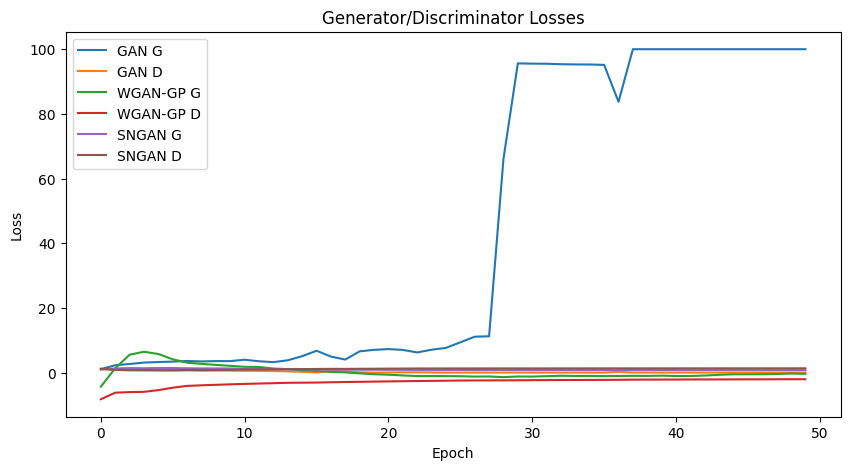

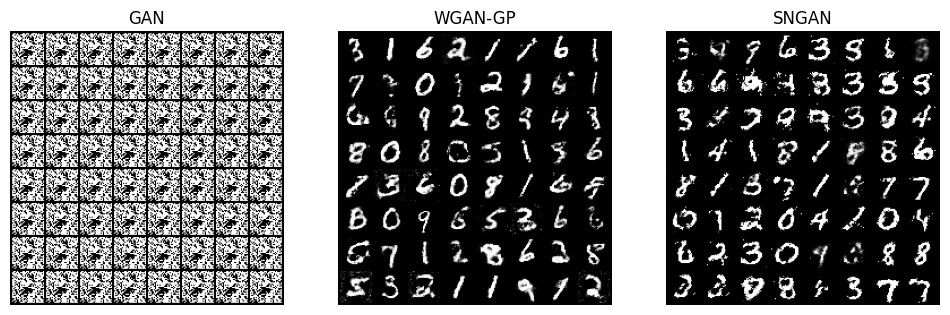

In [11]:
# Instantiate
G = Generator()
D = Discriminator()
WG = Generator()
WD = WDiscriminator()
SG = Generator()
SD = SNDiscriminator()

# Train
loss_gan = train_gan(G, D, loader, 'samples_gan', epochs=50)
loss_wgan = train_wgan(WG, WD, loader, 'samples_wgan', epochs=50, gp_lambda=10)
loss_sngan = train_sngan(SG, SD, loader, 'samples_sngan', epochs=50)

# Compare Losses
loss_dict = {
    "GAN": loss_gan,
    "WGAN-GP": loss_wgan,
    "SNGAN": loss_sngan
}
plot_loss_curves(loss_dict)

# Visualize Final Samples
def show_sample_grid(path, title):
    img = plt.imread(path)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
show_sample_grid('samples_gan/epoch_050.png', 'GAN')
plt.subplot(1,3,2)
show_sample_grid('samples_wgan/epoch_050.png', 'WGAN-GP')
plt.subplot(1,3,3)
show_sample_grid('samples_sngan/epoch_050.png', 'SNGAN')
plt.show()